# Option Pricing Engine Demo

This notebook provides a complete demonstration of the Monte Carlo option pricing engine, including pricing of European and exotic options, Greeks calculation, and convergence analysis.

## 1. Setup and Imports

We begin by importing all necessary classes and functions from the project's files.

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any, Callable, Optional, List

# Local files must be in the same directory as the notebook
from pricing import MCPricingEngine, black_scholes_call, black_scholes_put
from exotic_options import ExoticOptionsEngine
from greeks import GreeksEngine
from convergence_analysis import ConvergenceAnalyzer

# Configure matplotlib display settings for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## 2. Defining Option Parameters

Here we set the standard financial parameters that will be used for the various simulations.

In [25]:
# Standard parameters for options
S0 = 100.0   # Initial stock price
K = 100.0    # Strike price
T = 1.0      # Time to maturity (in years)
r = 0.05     # Risk-free rate
sigma = 0.2  # Volatility
M = 100000   # Number of simulations (paths)
N = 100      # Number of time steps

## 3. Pricing European Options

We use the Monte Carlo pricing engine and compare the results with the analytical Black-Scholes solution for validation. **Antithetic variates** are enabled by default for improved efficiency.

In [27]:
print("--- European Option Pricing ---")

# Initialize the pricing engine
engine = MCPricingEngine(seed=42)

# Analytical price (Black-Scholes) for reference
bs_call_price = black_scholes_call(S0, K, T, r, sigma)
bs_put_price = black_scholes_put(S0, K, T, r, sigma)

print(f"Theoretical (Black-Scholes) call price: {bs_call_price:.6f}")
print(f"Theoretical (Black-Scholes) put price:  {bs_put_price:.6f}")

print("\n--- Monte Carlo Pricing ---")

# Pricing a European call with antithetic variates
mc_call_price = engine.european_call_mc(S0, K, T, r, sigma, M=M, antithetic=True)
mc_put_price = engine.european_put_mc(S0, K, T, r, sigma, M=M, antithetic=True)

print(f"MC Call Price (Antithetic): {mc_call_price:.6f} (Error: {abs(mc_call_price - bs_call_price):.6f})")
print(f"MC Put Price (Antithetic):  {mc_put_price:.6f} (Error: {abs(mc_put_price - bs_put_price):.6f})")

--- European Option Pricing ---
Theoretical (Black-Scholes) call price: 10.450584
Theoretical (Black-Scholes) put price:  5.573526

--- Monte Carlo Pricing ---
MC Call Price (Antithetic): 10.452439 (Error: 0.001855)
MC Put Price (Antithetic):  5.598402 (Error: 0.024876)


## 4. Variance Reduction with Control Variates

This section demonstrates the effectiveness of **control variates** in improving the accuracy of the Monte Carlo price estimate by significantly reducing the variance of the results.

In [29]:
print("--- Improvement with Control Variates ---")

# Pricing a call with control variates
mc_plain_price, mc_cv_price = engine.european_call_mc(
    S0, K, T, r, sigma, M=M, antithetic=True, control_variate=True
)

print(f"MC Price without Control Variate: {mc_plain_price:.6f} (Error: {abs(mc_plain_price - bs_call_price):.6f})")
print(f"MC Price with Control Variate: {mc_cv_price:.6f} (Error: {abs(mc_cv_price - bs_call_price):.6f})")

--- Improvement with Control Variates ---
MC Price without Control Variate: 10.460005 (Error: 0.009421)
MC Price with Control Variate: 10.463779 (Error: 0.013196)


## 5. Pricing Exotic Options

The engine is designed to handle more complex path-dependent options, such as Asian or Barrier options.

In [31]:
print("--- Exotic Option Pricing ---")

exotic_engine = ExoticOptionsEngine(seed=42)
M_exotic = 50000 # Fewer simulations for exotic options
N_exotic = 252 # More time steps for path-dependent options

# Asian option (arithmetic average)
asian_price = exotic_engine.asian_call_mc(S0, K, T, r, sigma, M=M_exotic, N=N_exotic, antithetic=True)
print(f"MC Asian Call Price: {asian_price:.6f}")

# Barrier option (Up-and-Out)
B = 120.0 # Barrier level
barrier_price = exotic_engine.barrier_up_out_call_mc(S0, K, B, T, r, sigma, M=M_exotic, N=N_exotic, antithetic=True)
print(f"MC Barrier Call Price: {barrier_price:.6f}")

--- Exotic Option Pricing ---
MC Asian Call Price: 5.814062
MC Barrier Call Price: 1.333541


## 6. Greeks Calculation

Greeks are measures of an option's sensitivity to changes in underlying parameters. We calculate them here using the **finite difference** method.

In [33]:
print("--- Greeks Calculation ---")

greeks_engine = GreeksEngine(seed=42)

# Define parameters for Greeks calculation
params = {'S0': S0, 'K': K, 'T': T, 'r': r, 'sigma': sigma, 'M': M}

# Calculate all Greeks using the central finite difference method
all_greeks = greeks_engine.compute_all_greeks(
    pricing_func=engine.european_call_mc,
    params=params,
    method='central'
)
print("Greeks (Finite Differences):")
for greek, value in all_greeks.items():
    print(f"  {greek.capitalize()}: {value:.6f}")
    
# Calculate Delta using the pathwise method (more accurate for smooth options)
pathwise_delta = greeks_engine.pathwise_delta(S0, K, T, r, sigma, 'call', M=M)
print(f"\nDelta (pathwise method): {pathwise_delta:.6f}")

--- Greeks Calculation ---
Greeks (Finite Differences):
  Delta: 59.914433
  Gamma: -2394490.337557
  Vega: 36.837607
  Theta: -21.097434
  Rho: 50.594577

Delta (pathwise method): 0.637394


## 7. Convergence Analysis

This final section shows how the accuracy of the Monte Carlo estimate improves as the number of simulations increases, demonstrating the convergence law of $O(1/\sqrt{M})$.

--- Monte Carlo Convergence Analysis ---


KeyError: 'M_values'

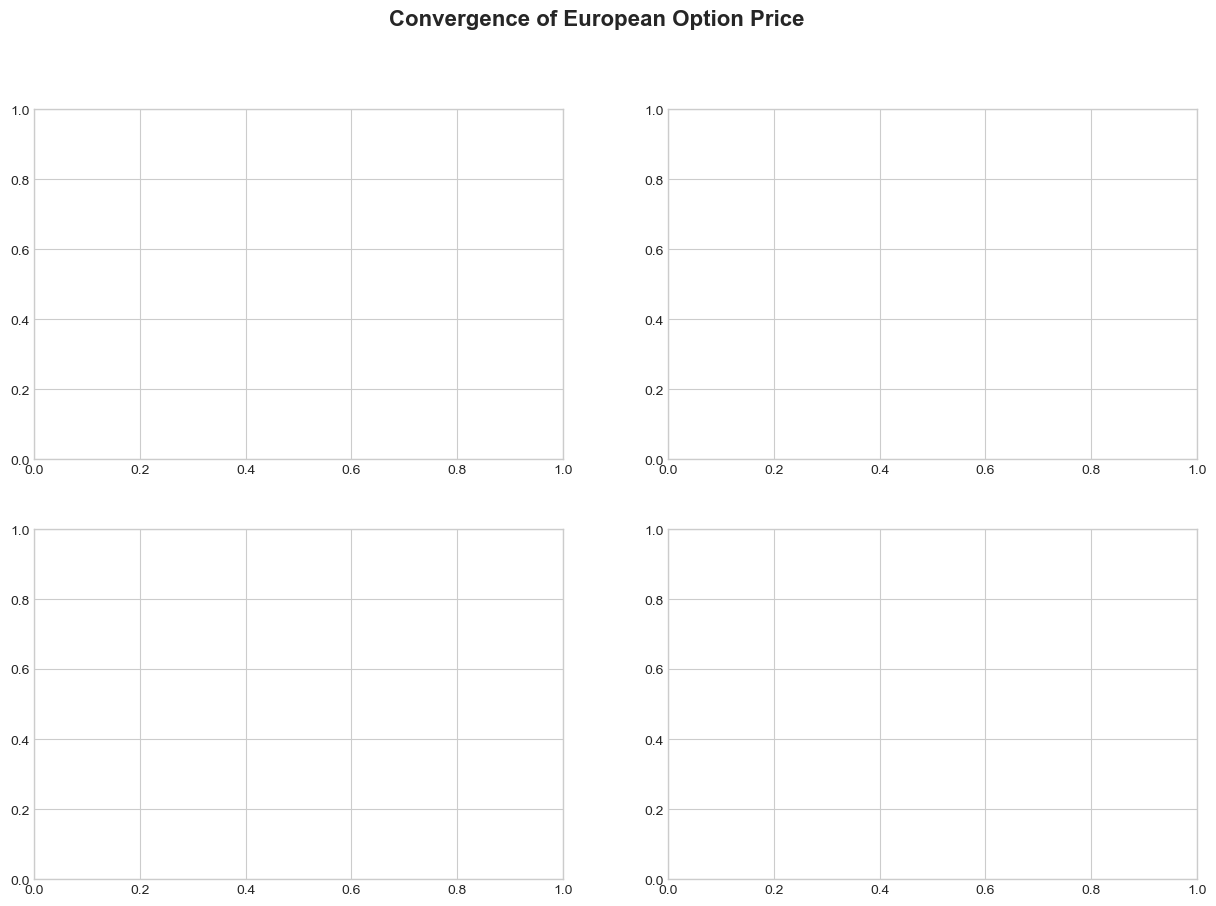

In [17]:
print("--- Monte Carlo Convergence Analysis ---")

analyzer = ConvergenceAnalyzer(seed=42)

# Define the number of simulations to test
M_values = np.logspace(3, 6, 10, dtype=int)
n_trials = 20  # Number of trials per M value for better statistics

# Theoretical price for comparison
true_price = black_scholes_call(S0, K, T, r, sigma)

# Analyze convergence
convergence_results = analyzer.monte_carlo_convergence(
    pricing_func=engine.european_call_mc,
    true_price=true_price,
    M_values=M_values,
    n_trials=n_trials,
    S0=S0, K=K, T=T, r=r, sigma=sigma, antithetic=True
)

# Plot the results
fig = analyzer.plot_convergence(convergence_results, true_price, title="Convergence of European Option Price")
plt.show(fig)

## 8. Variance Reduction Analysis (Quick Overview)

In [43]:
print("--- Variance Reduction Analysis ---")

cv_results = analyzer.control_variates_analysis(
    pricing_func=engine.european_call_mc,
    true_price=true_price,
    M=M,
    n_trials=50,
    S0=S0, K=K, T=T, r=r, sigma=sigma, antithetic=True
)

print(f"MC Variance without Control: {cv_results['plain_variance']:.8f}")
print(f"MC Variance with Control: {cv_results['cv_variance']:.8f}")
print(f"Variance Reduction: {cv_results['variance_reduction']:.2f}x")
print(f"Net Efficiency Gain: {cv_results['efficiency']:.2f}x")

--- Variance Reduction Analysis ---
MC Variance without Control: 0.00098575
MC Variance with Control: 0.00127378
Variance Reduction: 0.77x
Net Efficiency Gain: 0.76x
